In [1]:
import torch
from torch import Tensor
import typing as tp
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


# Content from functional.py
FAN_IN:tp.TypeAlias = int
FAN_OUT:tp.TypeAlias = int
KERNEL_SIZE:tp.TypeAlias = tuple[int, int]
STRIDES:tp.TypeAlias = tuple[int, int]


def linear_forward(
    x:Tensor,      # (B, fi)
    wie:Tensor,    # (fo, fi)
    bias:Tensor,   # (fo,)
):
    return x @ wie.transpose(-1, -2) + bias.unsqueeze(0) 

def linear_backward(
    x:Tensor,       # (B, fi)
    wie:Tensor,     # (fo, fi)
    bias:Tensor,    # (fo,) # we dont need this anyway
    dL_dO:Tensor,   # (B, fo)
):
    dL_dx = dL_dO @ wie      # (B, fi) <= (B, fo) @ (fo, fi)
    dL_dwie = dL_dO.transpose(-1, -2) @ x    # (fo, fi) <= (B, fo).T @ (B, fi)
    dL_db = dL_dO.sum(dim=0) # (fo,) <= (B, fo)
    return dL_dx, dL_dwie, dL_db


def reshape_forward(x:Tensor, shape:tuple): # (B, C, H, W)
    return x.reshape(shape), x.shape        # (B, C*H*W), (B, C, H, W)


def reshape_backward(dL_dO:Tensor, x_shape:torch.Size): # (B, C*H*W)
    return dL_dO.reshape(x_shape)                       # (B, C, H, W)

def _conv2d(
    x:Tensor, # (H, W)
    w:Tensor, # (h, w)
    full:bool=False,
    convolve:bool=False
):
    x = x[None, None, ...] # (1, 1, H, W)
    w = w[None, None, ...] # (1, 1, h, w)
    if full:
        pad_h = w.size(-2) - 1
        pad_w = w.size(-1) - 1
        x = F.pad(x, (pad_w, pad_w, pad_h, pad_h), mode='constant')
    if convolve:
        w = w.flip((2, 3))
    return F.conv2d(
        input=x, # (1, 1, H, W)
        weight=w, # (1, 1, h, w)
        stride=1
    )[0, 0, :, :]


def _dilate_matrix(x:Tensor, dilation:tuple[int, int]):
    """`x: shape(B, C, H, W)`\n `dilation:tuple`"""
    (B, C, H, W), (Hd, Wd)  = x.shape, dilation
    dilated = torch.zeros((B, C, Hd*(H-1)+1, Wd*(W-1)+1 ), device=x.device, dtype=x.dtype)
    dilated[:, :, ::Hd, ::Wd] = x
    return dilated


def conv2d_forward(
    x:Tensor,               # (B, fi, H, W) 
    wie:Tensor,               # (fo, fi, h, w)
    bias:tp.Optional[Tensor],  # (fo,)
    stride:STRIDES = (1, 1)
):
    B, C, H, W = x.shape
    fo, fi, h, w = wie.shape
    sh, sw = stride
    assert C == fi, f"Expected {C} == {fi}"
    assert H >= h, f"Expected {H} >= {h}"
    assert W >= w, f"Expected {W} >= {w}"
    if bias is not None:
        assert bias.shape[0] == fo, f"Expected {bias.shape[0]} == {fo}"

    output_shape = (B, fo, int((H-h)//sh + 1), int((W-w)//sw + 1))
    out = torch.zeros(output_shape, device=x.device, dtype=x.dtype) # (B, C_out, H1, W1)
    for fan_out in range(fo):
        for fan_in in range(fi):
            for bdim in range(B):
                out[bdim, fan_out] += _conv2d(x[bdim, fan_in], wie[fan_out, fan_in])[::sh, ::sw]

    if bias is not None:
        out += bias.view(1, -1, 1, 1)
    return out


def conv2d_backward(
    x:Tensor,                   # (B, fi, H, W)
    wei:Tensor,                 # (fo, fi, h, w)
    bias:tp.Optional[Tensor],   # (fo,)
    dL_dO:Tensor,               # (B, fo, H1, W1)
    stride:STRIDES = (1, 1)
):  
    fo, fi, h, w = wei.shape
    B, C, H, W = x.shape

    dL_dx, dL_dwei = torch.zeros_like(x), torch.zeros_like(wei)
    dL_dO = _dilate_matrix(dL_dO, dilation=stride)
    for fan_out in range(fo): # C_out
        for bdim in range(B): # B
            for fan_in in range(fi): # C_in
                dL_dwei[fan_out, fan_in] += _conv2d(x[bdim, fan_in], dL_dO[bdim, fan_out]) # (H, W)*(H1, W1) => (Hk, Wk)
                dL_dx[bdim, fan_in] += _conv2d(dL_dO[bdim, fan_out], wei[fan_out, fan_in], full=True, convolve=True) # (H1, W1)*(Hk, Wk) => (H, W)
    
    dL_db = dL_dO.sum(dim=(0, 2, 3)) if bias is not None else None
    return dL_dx, dL_dwei, dL_db


def _maxpool(matrix:Tensor, kernel_size:KERNEL_SIZE, strides:STRIDES): # (H, W)
        (H, W), (Hk, Wk), (Hs, Ws) = matrix.shape, kernel_size, strides
        output_shape = ((H-Hk+1)//Hs + 1, (W-Wk+1)//Ws + 1)
        indices, maxpooled = [], []
        for i in range(0, H - Hk + 1, Hs):
            for j in range(0, W - Wk + 1, Ws):
                window = matrix[i:i+Hk, j:j+Wk]
                max_index = torch.unravel_index(torch.argmax(window), window.shape)
                max_index_global = (max_index[0] + i, max_index[1] + j)
                indices.append(max_index_global)
                maxpooled.append(window[max_index])
        maxpooled = torch.stack(maxpooled).reshape(output_shape)
        indices = torch.tensor(indices) # (H1*W1, 2)
        return maxpooled, (indices[:, 0].reshape(output_shape), indices[:, 1].reshape(output_shape))

def channeled_maxpool(matrix:Tensor, kernel_size:KERNEL_SIZE, strides:STRIDES): # (C, H, W)
    (C, H, W) = matrix.shape
    maxpooled, Rindices, Cindices = [], [], []
    for c in range(C):
        maxpooled_, (indices_r, indices_c) = _maxpool(matrix[c], kernel_size, strides)
        maxpooled.append(maxpooled_)
        Rindices.append(indices_r)
        Cindices.append(indices_c)
    return torch.stack(maxpooled), (torch.stack(Rindices), torch.stack(Cindices))


def vmaxpool(matrix:Tensor, kernel_size:KERNEL_SIZE, strides:STRIDES): # (B, C, H, W)
    (B, C, H, W) = matrix.shape
    maxpooled, Rindices, Cindices = [], [], []
    for b in range(B):
        maxpooled_b, (indices_r, indices_c) = channeled_maxpool(matrix[b], kernel_size, strides)
        maxpooled.append(maxpooled_b)
        Rindices.append(indices_r)
        Cindices.append(indices_c)
    return torch.stack(maxpooled), (torch.stack(Rindices), torch.stack(Cindices))


def maxpool2d_forward(
    x:Tensor,
    kernel_size:KERNEL_SIZE,
    strides:STRIDES,
) -> tuple[Tensor, tuple[Tensor, Tensor], torch.Size]:
    O, (ridx, cidx) = vmaxpool(x, kernel_size, strides)
    return O, (ridx, cidx), x.shape


def maxpool2d_backward(
    dL_dO: Tensor,
    x_shape: torch.Size,
    indices: tuple[Tensor, Tensor],
):
    (ridx, cidx) = indices
    dL_dX = torch.zeros(x_shape, device=dL_dO.device)
    B, C, H, W = dL_dO.shape
    for b in range(B):
        for c in range(C):
            dL_dO_bc = dL_dO[b, c]
            ridx_bc = ridx[b, c]
            cidx_bc = cidx[b, c]
            dL_dX[b, c, ridx_bc, cidx_bc] += dL_dO_bc
    return dL_dX


def relu_forward(x:Tensor):
    return torch.maximum(x, torch.zeros((), dtype=x.dtype, device=x.device))


def relu_backward(relu:Tensor, dL_dO:Tensor):
    return dL_dO * (relu > 0).to(relu.dtype)


def softmax_forward(logits:Tensor):
    max_val, idx = logits.max(-1, keepdim=True) 
    logits -= max_val
    exp = torch.exp(logits)
    proba = exp / exp.sum(-1, keepdim=True)
    return proba


def softmax_backward(probs:Tensor, dL_dprobs:Tensor):
    nc = probs.shape[-1]
    t1 = torch.einsum("ij,ik->ijk", probs, probs)
    t2 = torch.einsum("ij,jk->ijk", probs, torch.eye(nc, nc, device=probs.device, dtype=probs.dtype))
    dprobs_dlogits = t2 - t1
    dL_dlogits = (dL_dprobs[:, None, :] @ dprobs_dlogits)[:, 0, :]
    return dL_dlogits


def cross_entropy_forward(y_true:Tensor, y_proba:Tensor):
    log_probs = torch.log(y_proba)
    loss = -log_probs[torch.arange(len(y_true)), y_true].mean()
    return loss


def cross_entropy_backward(y_true:Tensor, y_proba:Tensor):
    B = len(y_true)
    dL_dlogprobas = torch.zeros_like(y_proba)
    dL_dlogprobas[torch.arange(B), y_true] = -1/B
    dlogprobas_dprobas = 1/y_proba
    dL_dprobas = dL_dlogprobas * dlogprobas_dprobas
    return dL_dprobas


# Content from nn.py
_sqrt = lambda x: x**0.5
_prod = lambda x: x[0]*x[1]

class Module:
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    def backward(self, *args, **kwargs):
        raise NotImplementedError
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def to(self, device):
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Tensor):
                setattr(self, attr_name, attr.to(device))
            elif isinstance(attr, Module):
                attr.to(device)
        return self


class Linear(Module):
    def __init__(self, fan_in:int, fan_out:int):
        super().__init__()
        bound = _sqrt(2/fan_in)
        self.wie = torch.randn(fan_out, fan_in).uniform_(-bound, bound)
        self.bias = torch.randn(fan_out)

    def forward(self, x:Tensor):
        return linear_forward(x, self.wie, self.bias)
    def backward(self, x:Tensor, dL_dO:Tensor):
        return linear_backward(x, self.wie, self.bias, dL_dO)


class Reshape(Module):
    def __init__(self, shape:tuple):
        super().__init__()
        self.shape = shape

    def forward(self, x:Tensor):
        self.x_shape = x.shape
        reshaped, _ = reshape_forward(x, self.shape)
        return reshaped
    def backward(self, dL_dO:Tensor):
        return reshape_backward(dL_dO, self.x_shape)


class Conv2d(Module):
    def __init__(
        self,
        in_channels:FAN_IN,
        out_channels:FAN_OUT,
        kernel_size:KERNEL_SIZE,
        strides:STRIDES,
        bias:bool=True
    ):
        bound = _sqrt(2/_prod(kernel_size))
        self.wei = torch.empty(size=(out_channels, in_channels, *kernel_size)).uniform_(-bound, bound)
        self.bias = torch.zeros(size=(out_channels,)) if bias else None
        self.strides = strides

    def forward(self, x:Tensor):
        self.x = x; return conv2d_forward(x, self.wei, self.bias, self.strides)
    def backward(self, dL_dO:Tensor):
        return conv2d_backward(self.x, self.wei, self.bias, dL_dO, self.strides)


class Maxpool2d(Module):
    def __init__(self, kernel_size:KERNEL_SIZE, strides:STRIDES):
        super().__init__()
        self.kernel_size = kernel_size
        self.strides = strides

    def forward(self, x:Tensor):
        out, self.idx, self.x_shape = maxpool2d_forward(x, self.kernel_size, self.strides)
        return out
    def backward(self, dL_dO:Tensor):
        return maxpool2d_backward(dL_dO, self.x_shape, self.idx)


class ReLU(Module):
    def forward(self, x:Tensor):
        self.relu = relu_forward(x)
        return self.relu
    def backward(self, dL_dO:Tensor):
        return relu_backward(self.relu, dL_dO)


class Softmax(Module):
    def forward(self, x:Tensor, axis:int=-1):
        assert axis == -1, "Softmax only supports the last axis... Hardcoded for Lenet :/"
        self.probs = softmax_forward(x)
        return self.probs
    def backward(self, dL_dO:Tensor):
        return softmax_backward(self.probs, dL_dO)


class CrossEntropy:
    def forward(self, y_true:Tensor, y_proba:Tensor):
        self.y_true = y_true
        self.y_proba = y_proba
        return cross_entropy_forward(y_true, y_proba)
    def backward(self):
        return cross_entropy_backward(self.y_true, self.y_proba)


# Content from lenet.py
class LeNet(Module):
    def __init__(self, num_classes:int = 10):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), strides=(1, 1), bias=True)
        self.pool1 = Maxpool2d(kernel_size=(2, 2), strides=(2, 2))
        self.conv2 = Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), strides=(1, 1), bias=True)
        self.pool2 = Maxpool2d(kernel_size=(2, 2), strides=(2, 2))
        self.flatten = Reshape(shape=(-1, 400))
        self.fc1 = Linear(fan_in=400, fan_out=120)
        self.relu1 = ReLU()
        self.fc2 = Linear(fan_in=120, fan_out=84)
        self.relu2 = ReLU()
        self.fc3 = Linear(fan_in=84, fan_out=num_classes)
        self.softmax = Softmax()
        self.criterion = CrossEntropy()
        self.activations = {}
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        self.activations['conv1'] = x
        x = self.pool1(x)
        self.activations['pool1'] = x
        x = self.conv2(x)
        self.activations['conv2'] = x
        x = self.pool2(x)
        self.activations['pool2'] = x
        x = self.flatten(x)
        self.activations['flatten'] = x
        x = self.fc1(x)
        self.activations['fc1'] = x
        x = self.relu1(x)
        self.activations['relu1'] = x
        x = self.fc2(x)
        self.activations['fc2'] = x
        x = self.relu2(x)
        self.activations['relu2'] = x
        x = self.fc3(x)
        self.activations['fc3'] = x
        x = self.softmax(x)
        self.activations['softmax'] = x
        return x
    
    def backward(self) -> dict:
        dL_dO = self.criterion.backward()
        dL_dO = self.softmax.backward(dL_dO)
        dL_dO, dL_dw3, dL_db3 = self.fc3.backward(self.activations['relu2'], dL_dO)
        dL_dO = self.relu2.backward(dL_dO)
        dL_dO, dL_dw2, dL_db2 = self.fc2.backward(self.activations['relu1'], dL_dO)
        dL_dO = self.relu1.backward(dL_dO)
        dL_dO, dL_dw1, dL_db1 = self.fc1.backward(self.activations['flatten'], dL_dO)
        dL_dO = self.flatten.backward(dL_dO)
        dL_dO = self.pool2.backward(dL_dO)
        dL_dO, dL_dw_conv2, dL_db_conv2 = self.conv2.backward(dL_dO)
        dL_dO = self.pool1.backward(dL_dO)
        dL_dinput, dL_dw_conv1, dL_db_conv1 = self.conv1.backward(dL_dO)
        
        return {
            'input_grad': dL_dinput,
            'conv1_weight_grad': dL_dw_conv1,
            'conv1_bias_grad': dL_db_conv1,
            'conv2_weight_grad': dL_dw_conv2,
            'conv2_bias_grad': dL_db_conv2,
            'fc1_weight_grad': dL_dw1,
            'fc1_bias_grad': dL_db1,
            'fc2_weight_grad': dL_dw2,
            'fc2_bias_grad': dL_db2,
            'fc3_weight_grad': dL_dw3,
            'fc3_bias_grad': dL_db3,
        }
    
    def compute_loss(self, x: Tensor, y_true: Tensor) -> Tensor:
        y_pred = self.forward(x)
        loss = self.criterion.forward(y_true, y_pred)
        return loss


In [2]:
# Content from train_lenet.py
device = "cpu"
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1] range
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

model = LeNet(num_classes=10).to(device)

num_epochs = 10
print("Starting training on Fashion MNIST...")
num_steps = 0; losses = []; accuracies = []
for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, labels) in enumerate(pbar):
        num_steps += 1
        images, labels = images.to(device), labels.to(device)
        
        loss = model.compute_loss(images, labels)
        gradients = model.backward()
        
        lr = 0.01
        with torch.no_grad():
            model.conv1.wei -= lr * gradients['conv1_weight_grad']
            model.conv1.bias -= lr * gradients['conv1_bias_grad']
            model.conv2.wei -= lr * gradients['conv2_weight_grad']
            model.conv2.bias -= lr * gradients['conv2_bias_grad']
            model.fc1.wie -= lr * gradients['fc1_weight_grad']
            model.fc1.bias -= lr * gradients['fc1_bias_grad']
            model.fc2.wie -= lr * gradients['fc2_weight_grad']
            model.fc2.bias -= lr * gradients['fc2_bias_grad']
            model.fc3.wie -= lr * gradients['fc3_weight_grad']
            model.fc3.bias -= lr * gradients['fc3_bias_grad']

        running_loss += loss.item()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Accuracy on the test set after epoch {epoch+1}: {accuracy:.2f}%")

    print(f"|| Epoch: {epoch+1} || Epoch Loss: {running_loss / len(train_loader):.4f} || Val Accuracy: {accuracy:.2f} ||")

print("Finished Training")

Using device: cpu
Starting training on Fashion MNIST...


Epoch 1/10: 100%|██████████| 1875/1875 [1:14:35<00:00,  2.39s/it, loss=0.3708]


|| Epoch: 1 || Epoch Loss: 0.6296 ||
Accuracy on the test set after epoch 1: 81.29%


Epoch 2/10: 100%|██████████| 1875/1875 [1:14:47<00:00,  2.39s/it, loss=0.5229]


|| Epoch: 2 || Epoch Loss: 0.4400 ||
Accuracy on the test set after epoch 2: 84.45%


Epoch 3/10: 100%|██████████| 1875/1875 [1:14:32<00:00,  2.39s/it, loss=0.2298]


|| Epoch: 3 || Epoch Loss: 0.3820 ||
Accuracy on the test set after epoch 3: 85.79%


Epoch 4/10: 100%|██████████| 1875/1875 [1:14:30<00:00,  2.38s/it, loss=0.5358]


|| Epoch: 4 || Epoch Loss: 0.3483 ||
Accuracy on the test set after epoch 4: 85.78%


Epoch 5/10: 100%|██████████| 1875/1875 [1:14:09<00:00,  2.37s/it, loss=0.1256]


|| Epoch: 5 || Epoch Loss: 0.3247 ||
Accuracy on the test set after epoch 5: 87.30%


Epoch 6/10: 100%|██████████| 1875/1875 [1:14:13<00:00,  2.38s/it, loss=0.1474]


|| Epoch: 6 || Epoch Loss: 0.3073 ||
Accuracy on the test set after epoch 6: 87.80%


Epoch 7/10: 100%|██████████| 1875/1875 [1:14:13<00:00,  2.38s/it, loss=0.5153]


|| Epoch: 7 || Epoch Loss: 0.2910 ||
Accuracy on the test set after epoch 7: 87.95%


Epoch 8/10:  12%|█▏        | 216/1875 [08:33<1:05:42,  2.38s/it, loss=0.3905]


KeyboardInterrupt: 

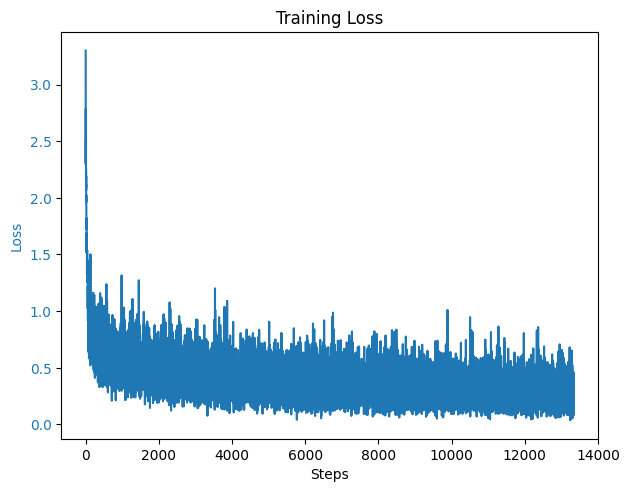

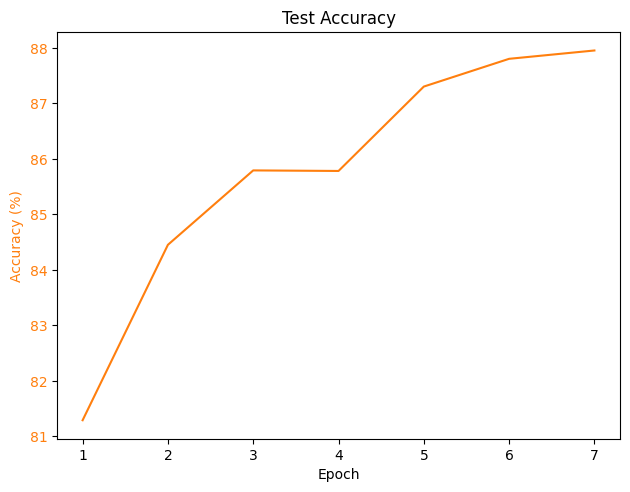

In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Training Loss')
plt.show()

fig2, ax2 = plt.subplots()
color = 'tab:orange'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(range(1, len(accuracies) + 1), accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
fig2.tight_layout()
plt.title('Test Accuracy')
plt.show()
ax1.plot(losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(
    [i * len(train_loader) for i in range(1, len(accuracies) + 1)],
    accuracies, color=color, label='Accuracy'
)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
import pickle
pickle.dump(losses, open("ckpt/lenet_train_losses.pkl", "wb"))
pickle.dump(accuracies, open("ckpt/lenet_val_accuracies.pkl", "wb"))